In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch

batch_size = 1

torch.manual_seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = MNIST('./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [3]:
from diff_unet import Unet

img = next(iter(data_loader))[0]
t = torch.randint(0, 100, (batch_size,))

batch_size, channels, height, width = img.shape

unet = Unet(dim=height,
            channels=channels,
            dim_mults=(1,),
            resnet_block_groups=7,
            use_convnext=False)

from torchinfo import summary

summary(unet, [(batch_size, channels, height, width), (batch_size,)], depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
Unet                                               [1, 1, 28, 28]            --
├─Conv2d: 1-1                                      [1, 18, 28, 28]           900
├─Sequential: 1-2                                  [1, 112]                  --
│    └─SinusoidalPositionEmbeddings: 2-1           [1, 28]                   --
│    └─Linear: 2-2                                 [1, 112]                  3,248
│    └─GELU: 2-3                                   [1, 112]                  --
│    └─Linear: 2-4                                 [1, 112]                  12,656
├─ModuleList: 1-3                                  --                        --
│    └─ModuleList: 2-5                             --                        47,376
├─ResBlock: 1-4                                    [1, 28, 28, 28]           --
│    └─Block: 2-6                                  [1, 28, 28, 28]           7,140
│    └─Sequential: 2

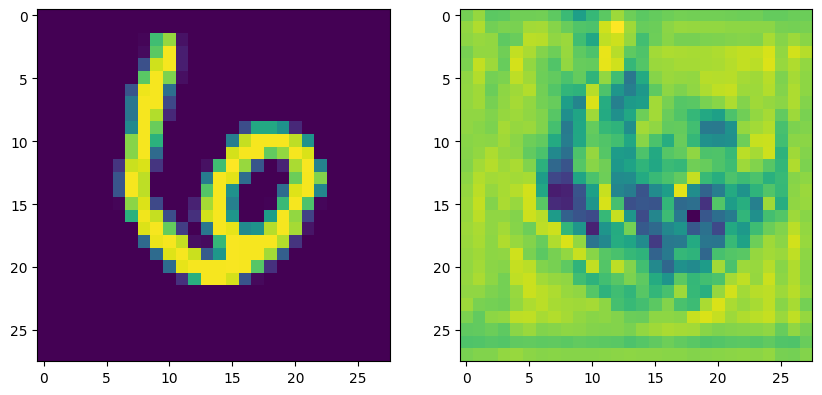

In [4]:
import matplotlib.pyplot as plt

out = unet(img, t)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0, 0, :, :].detach().numpy());
ax[1].imshow(out[0, 0, :, :].detach().numpy());

In [5]:
# Print unet attributes
dir(unet)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_ver

In [6]:
for param in unet.parameters():
    print(param.shape)

torch.Size([18, 1, 7, 7])
torch.Size([18])
torch.Size([112, 28])
torch.Size([112])
torch.Size([112, 112])
torch.Size([112])
torch.Size([28, 112])
torch.Size([28])
torch.Size([28, 18, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28, 28, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28, 18, 1, 1])
torch.Size([28])
torch.Size([28, 112])
torch.Size([28])
torch.Size([28, 28, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28, 28, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([384, 28, 1, 1])
torch.Size([28, 128, 1, 1])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28, 112])
torch.Size([28])
torch.Size([28, 28, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([28, 28, 3, 3])
torch.Size([28])
torch.Size([28])
torch.Size([28])
torch.Size([384, 28, 1, 1])
torch.Size([28, 128, 1, 1])
torch.Size([28])
torch.Size([28])
torch.Size([28])

In [7]:
# Check activation saturation
# Nonlinearities used: GELU, SiLU (swish), softmax(attention)

activs = set()

for i, layer in enumerate(unet.modules()):
    print(i, layer)

0 Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(7, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(7, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Res